# Plot RCM domains

This notebook plots RCM domains and other shapes on a projected map

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os.path
import pandas as pd
import xarray as xr
import yaml
import json
from shapely.geometry import Polygon, shape

Display projection

In [2]:
# EUR-11 rotated lat-lon projection
proj = ccrs.RotatedPole(pole_longitude=-162., pole_latitude=39.25, central_rotated_longitude=0)

Some functions

In [3]:
def get_interior_borders(orog_file, dist=10):
  ds = xr.load_dataset(orog_file)
  lonsm = ds['lon'].values
  lonsm = np.where(lonsm > 180, lonsm-360, lonsm) # Avoid discontinuity at 0E
  latsm = ds['lat'].values
  ix = dist
  rval = []
  for iy in range(latsm.shape[0])[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  iy = len(latsm)-dist
  for ix in range(latsm.shape[1])[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  ix = len(latsm[0])-dist
  for iy in range(latsm.shape[0]-1,0,-1)[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  iy = dist
  for ix in range(latsm.shape[1]-1,0,-1)[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  return(Polygon(rval))

def save_geojson(obj, filename):
  if not os.path.exists(filename):
    with open(filename, 'w') as f:
      json.dump(obj.__geo_interface__, f)

def plot_domain(axis, orog_file, relax, **color):
  boundaries = get_interior_borders(orog_file, relax)
  save_geojson(boundaries, f'data/{key}.geojson')
  axis.add_geometries([boundaries], crs=lonlat, **color, zorder=3)
  # manually add labels
  proxy_artist.append(mpatches.Rectangle((0,0),1,0.1, **color))

def plot_domain_geojson(axis, geo_file, **color):
  with open(geo_file, 'r') as f:
      boundaries = shape(json.load(f))
  axis.add_geometries([boundaries], crs=lonlat, **color, zorder=3)
  proxy_artist.append(mpatches.Rectangle((0,0),1,0.1, **color))

def plot_cities(axis, names, **kwargs):
  city_info = pd.read_csv(
    'https://raw.githubusercontent.com/FPS-URB-RCC/CORDEX-CORE-WG/no-gp022-filter/city_info.csv',
    comment='#', dtype = dict(domain = 'category', ktype = 'category')
  )
  for city in names:
    citydf = city_info.query(f'city == "{city}"')
    axis.plot(citydf['lon'].values,citydf['lat'].values, zorder=3, transform=lonlat, **kwargs)

def do_plot(axis, item):
  if 'input' in item:
    style = plot_data['default'][item['input']]['style']
    if 'style' in item:
      style.update(item['style'])
    #print(style)
    if item['input'] == 'points':
      xs, ys = tuple(zip(*item['data']))
      axis.plot(xs, ys, zorder=3, transform=lonlat, **style)
    elif item['input'] == 'corners':
      xs, ys = tuple(zip(*item['data']))
      xs = list(xs + (xs[0],)) # close the polygon
      ys = list(ys + (ys[0],))
      axis.plot(xs, ys, zorder=3, transform=lonlat, **style)
    elif item['input'] == 'cities':
      plot_cities(axis, item['data'], **style)
    elif item['input'] == 'bbox':
      xs = [item['data'][k] for k in [0,1,1,0,0]]
      ys = [item['data'][k] for k in [2,2,3,3,2]]
      corners = np.array(list(zip(xs,ys)))
      dens = 10
      p = np.linspace(0,1,dens).reshape(dens,1)
      interp = corners[0,:].reshape(1,2)
      for k in range(0,4):
        interp = np.append(interp, (1-p)*corners[k,:] + p*corners[k+1,:], axis=0)
      axis.add_geometries([Polygon(interp)], crs=lonlat, **style, zorder=2)
      proxy_artist.append(mpatches.Rectangle((0,0),1,0.1, **style))
    elif item['input'] == 'netcdf':
      relax = item['relax'] if 'relax' in item else 1
      plot_domain(axis, item['data'], relax=relax, **style)
    elif item['input'] == 'geojson':
      plot_domain_geojson(axis, item['data'], **style)
    else:
      print(f'Unknown input type: {item["input"]}')

Load config file

In [4]:
with open('domains.yml', 'r') as f:
    plot_data = yaml.safe_load(f)

and plot

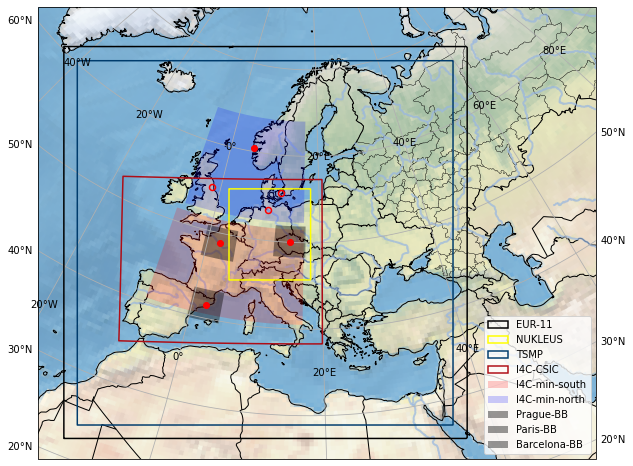

In [5]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1, projection=proj)
lonlat = ccrs.PlateCarree()
ax.set_extent([-15, 53, 25, 75], crs=lonlat)
ax.stock_img()
ax.gridlines(draw_labels=True)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25)
ax.add_feature(cfeature.RIVERS.with_scale('50m'), linewidth=2, alpha=0.7)
proxy_artist = []
legend_text = []
for key in plot_data:
  do_plot(ax, plot_data[key])
  legend_text.append(key)
ax.legend(proxy_artist, legend_text, loc='lower right', fancybox=True)
plt.savefig(f'./EURO-CORDEX-CP-domains.png', dpi = 150)


In [6]:
lon = 2.1328448712204127
lat = 41.5088700730
dlat = 200 * 180 / np.pi / 6370
dlon = dlat / np.cos(lat*np.pi/180)
[lon-dlon, lon+dlon, lat-dlat, lat+dlat]

[-0.2693959696557364, 4.535085712096562, 39.70994449959082, 43.307795646409176]